In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import seaborn as sns

from modules.utils.testing_utils import test_models

Importing plotly failed. Interactive plots will not work.


In [3]:
def sns_styleset():
    sns.set(context='paper', style='ticks', font='DejaVu Sans')
    matplotlib.rcParams['figure.dpi']        = 300
    matplotlib.rcParams['axes.linewidth']    = 1
    matplotlib.rcParams['xtick.major.width'] = 1
    matplotlib.rcParams['ytick.major.width'] = 1
    matplotlib.rcParams['xtick.major.size']  = 3
    matplotlib.rcParams['ytick.major.size']  = 3
    matplotlib.rcParams['xtick.minor.size']  = 2
    matplotlib.rcParams['ytick.minor.size']  = 2
    matplotlib.rcParams['font.size']         = 11
    matplotlib.rcParams['axes.titlesize']    = 11
    matplotlib.rcParams['axes.labelsize']    = 12
    matplotlib.rcParams['legend.fontsize']   = 10
    matplotlib.rcParams['xtick.labelsize']   = 10
    matplotlib.rcParams['ytick.labelsize']   = 10
    
sns_styleset()

## Peyton Manning

Testing peyton_manning with Prophet


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


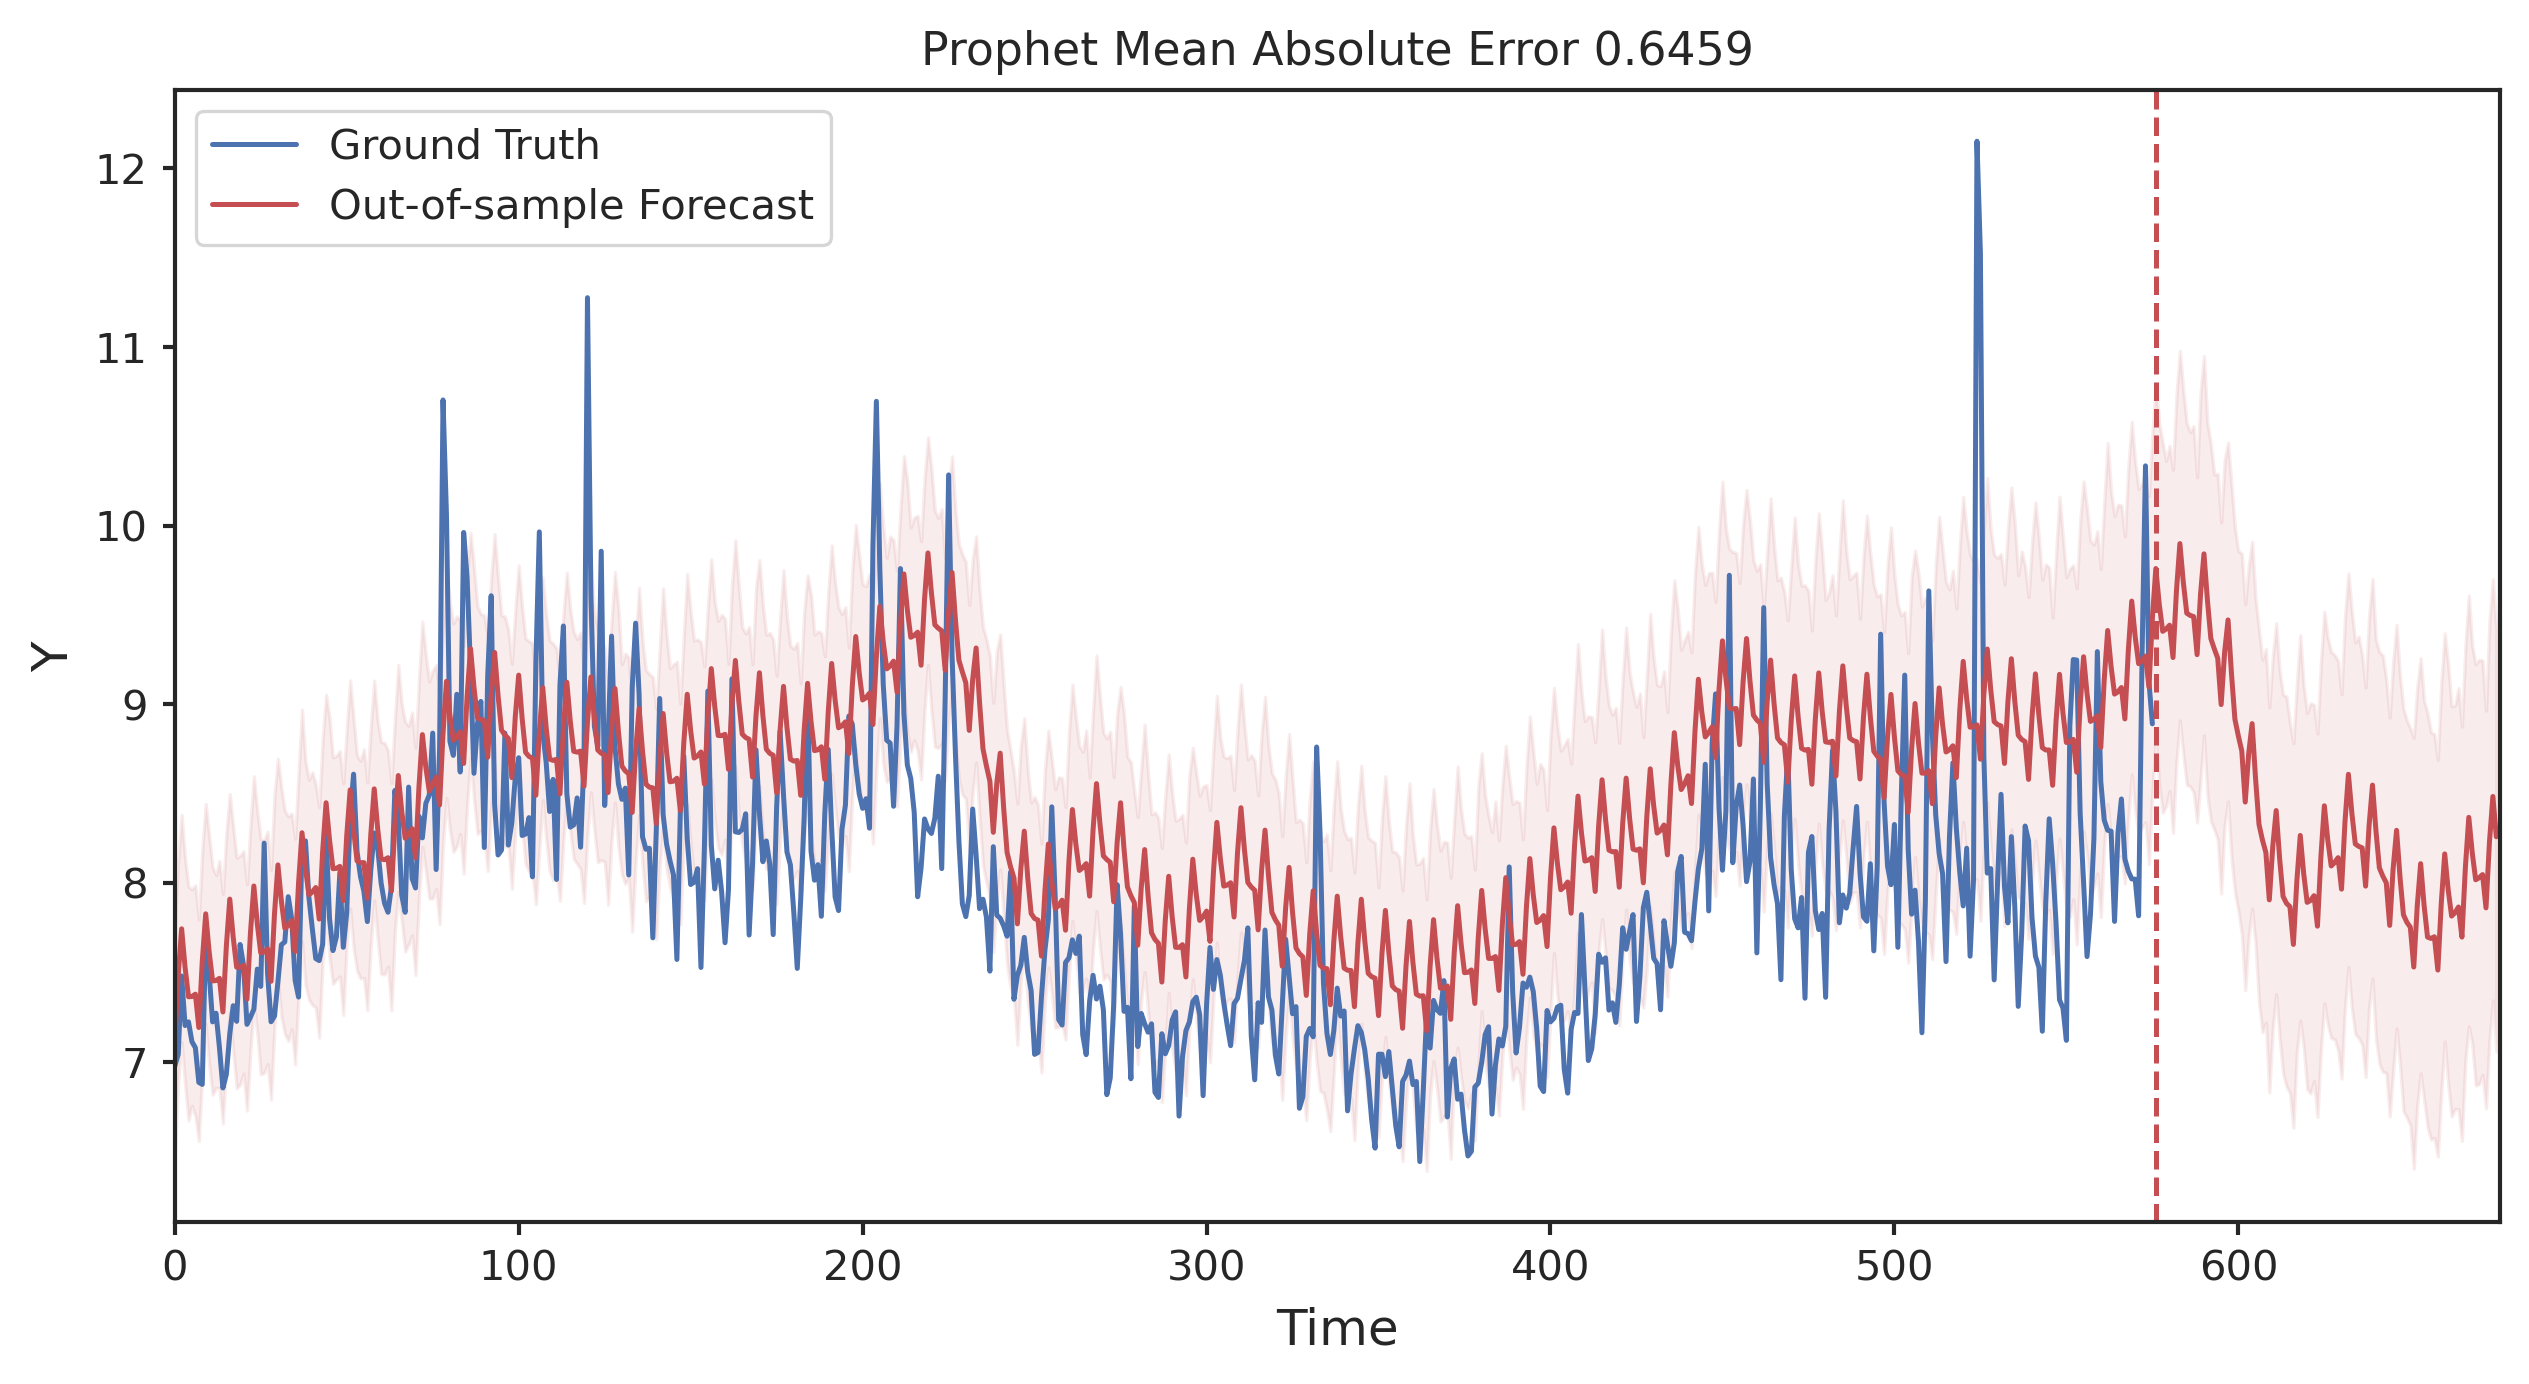

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [14:34<00:00, 29.14s/it]


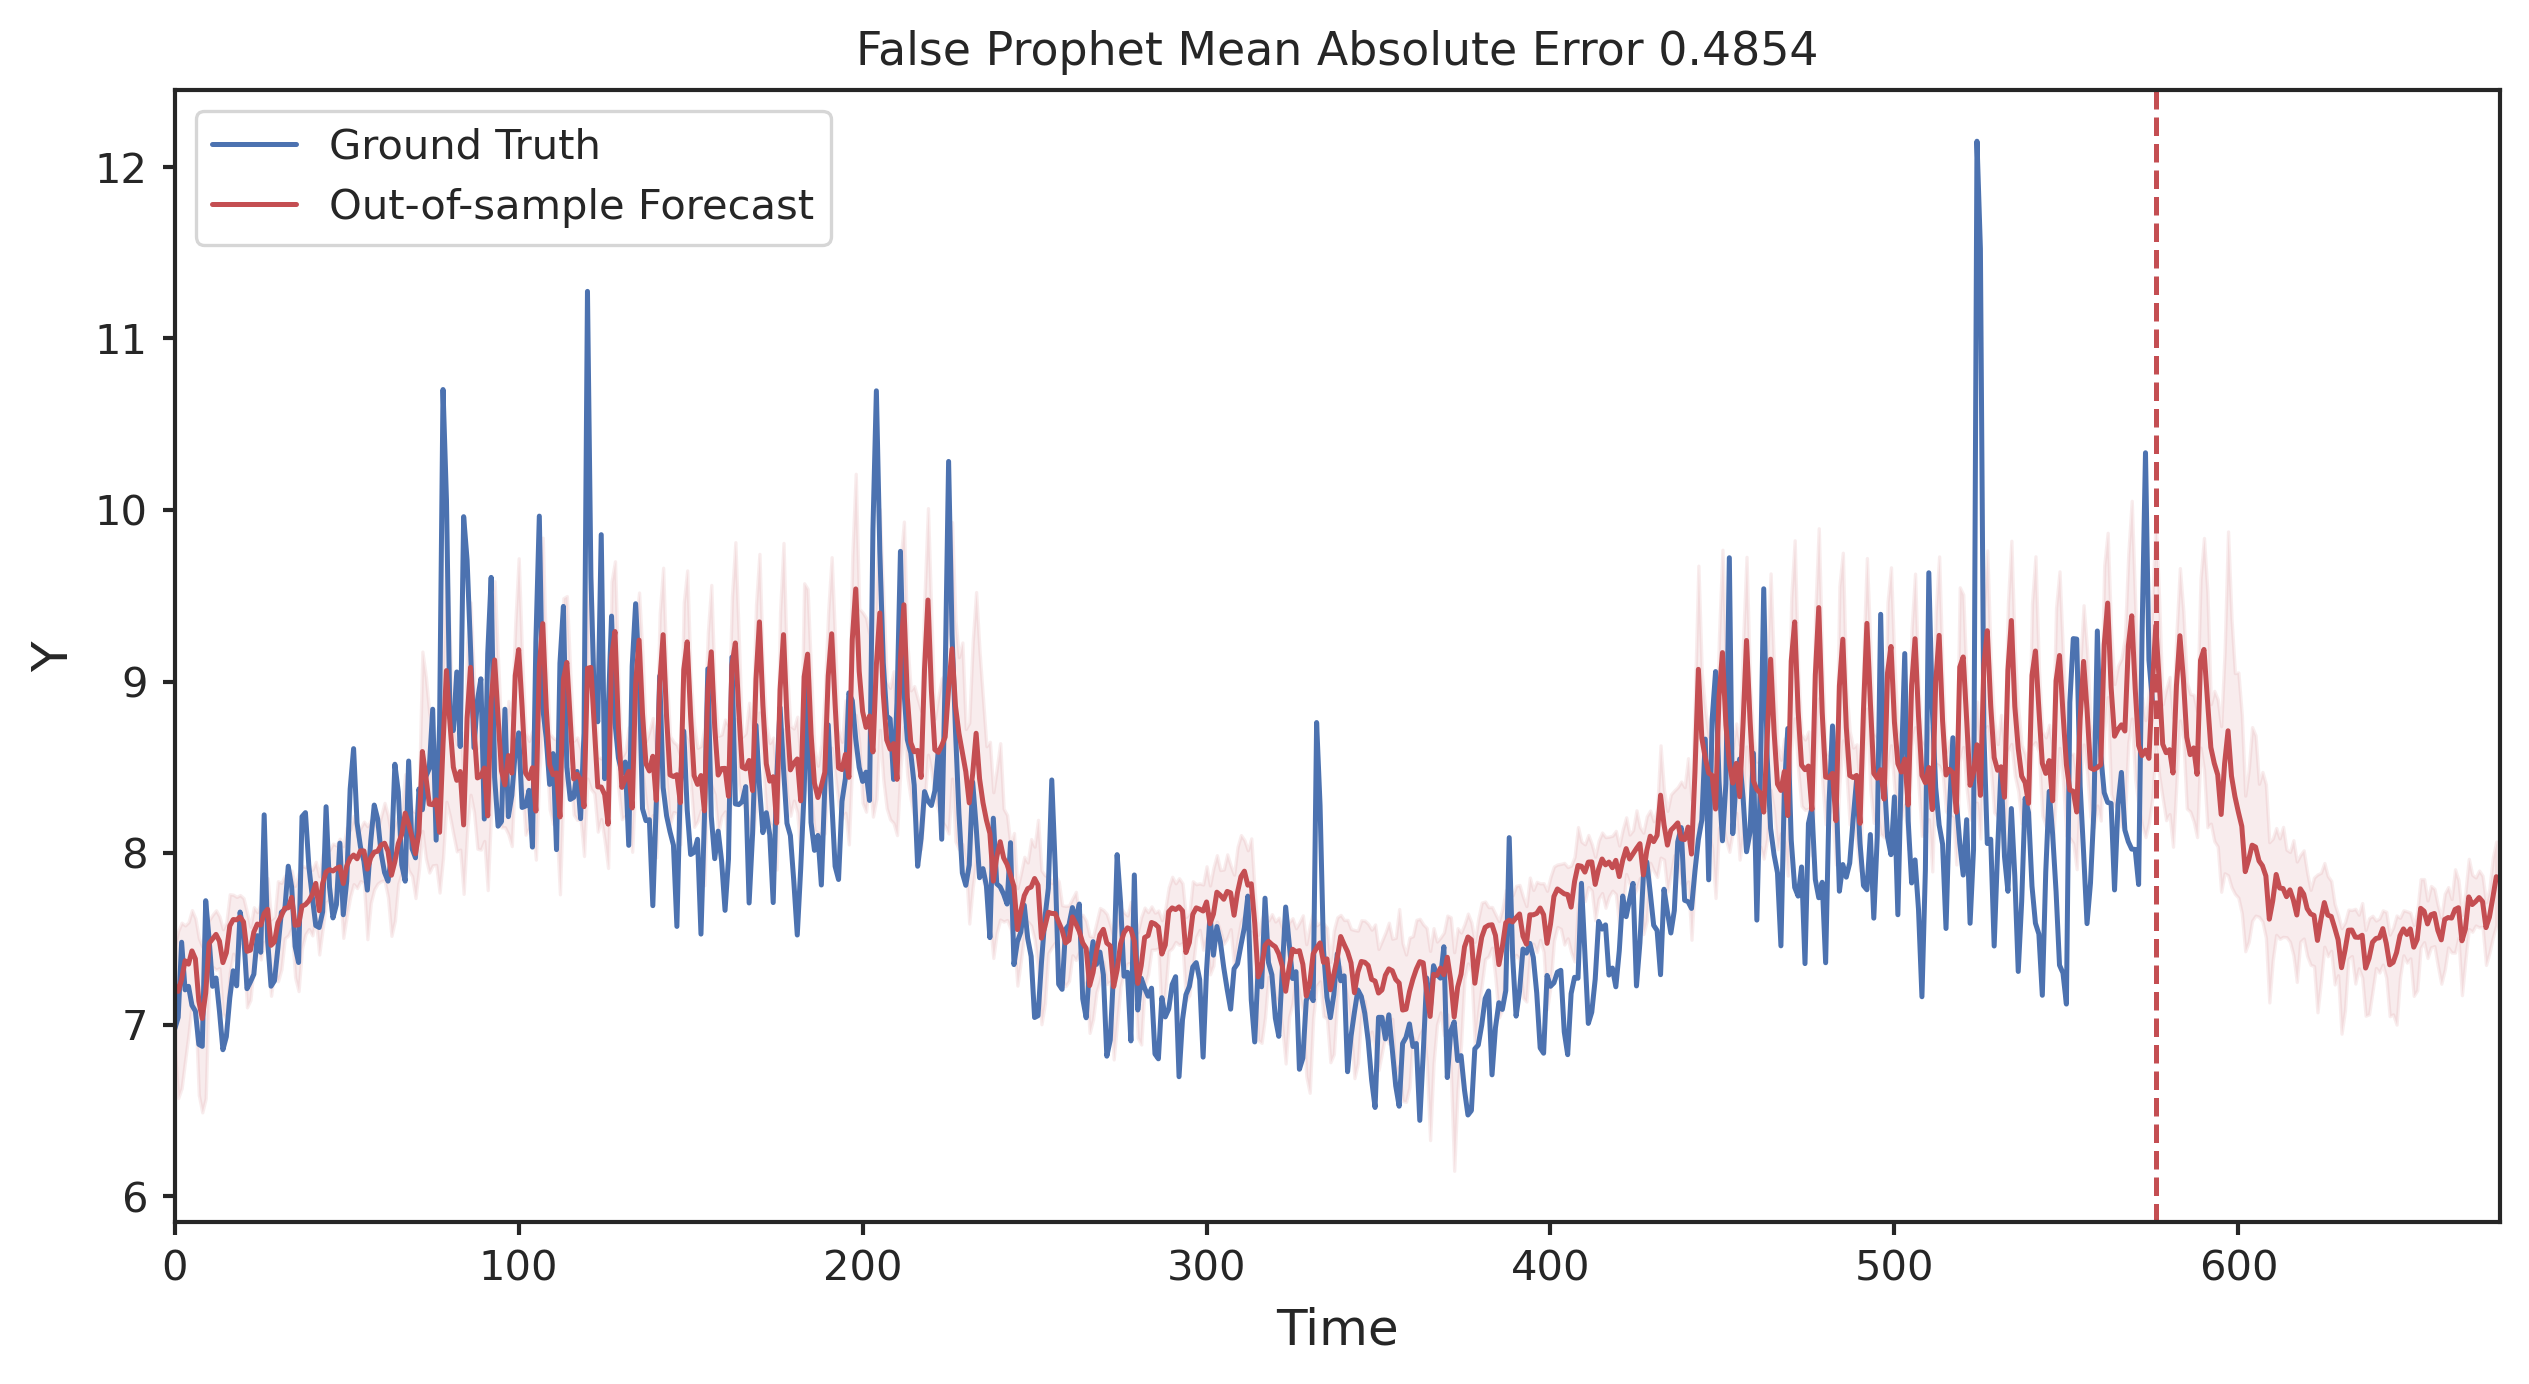

In [4]:
test_models(
    datasets={'peyton_manning': 576}, 
    periods=676, 
    figsize=(15, 5),
    n_boot=30
)

## Female Birth

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Testing female_birth with Prophet


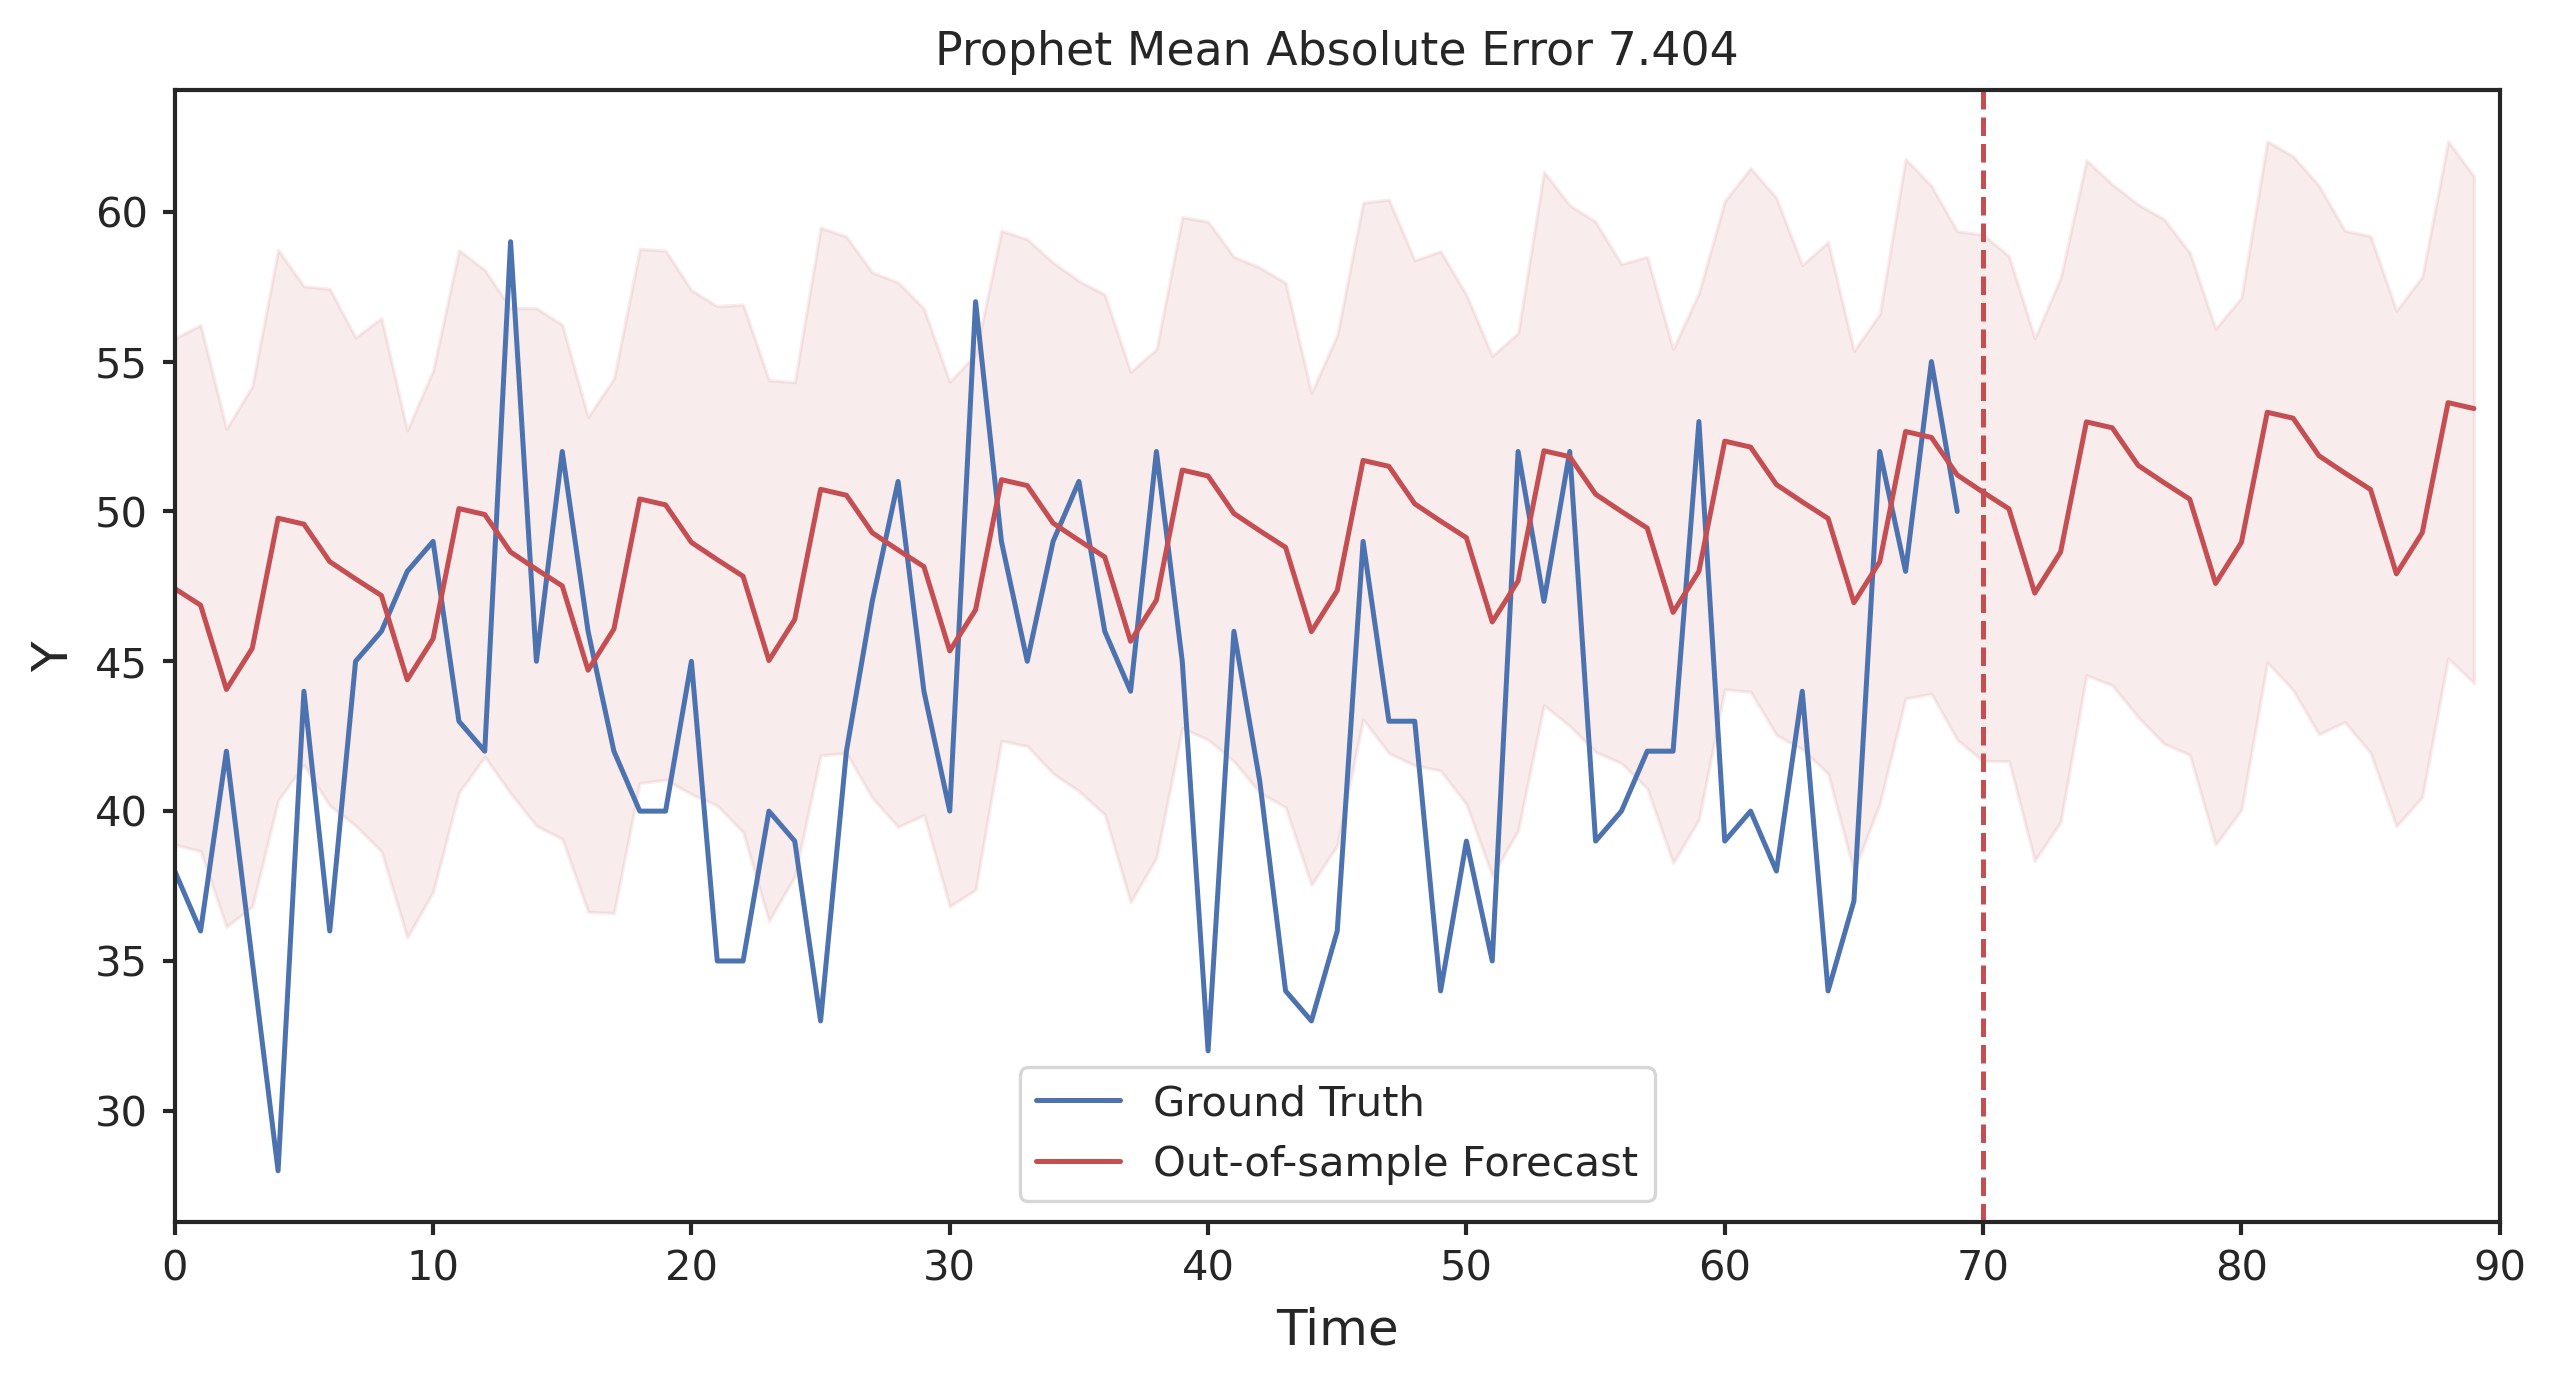

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:57<00:00,  3.90s/it]


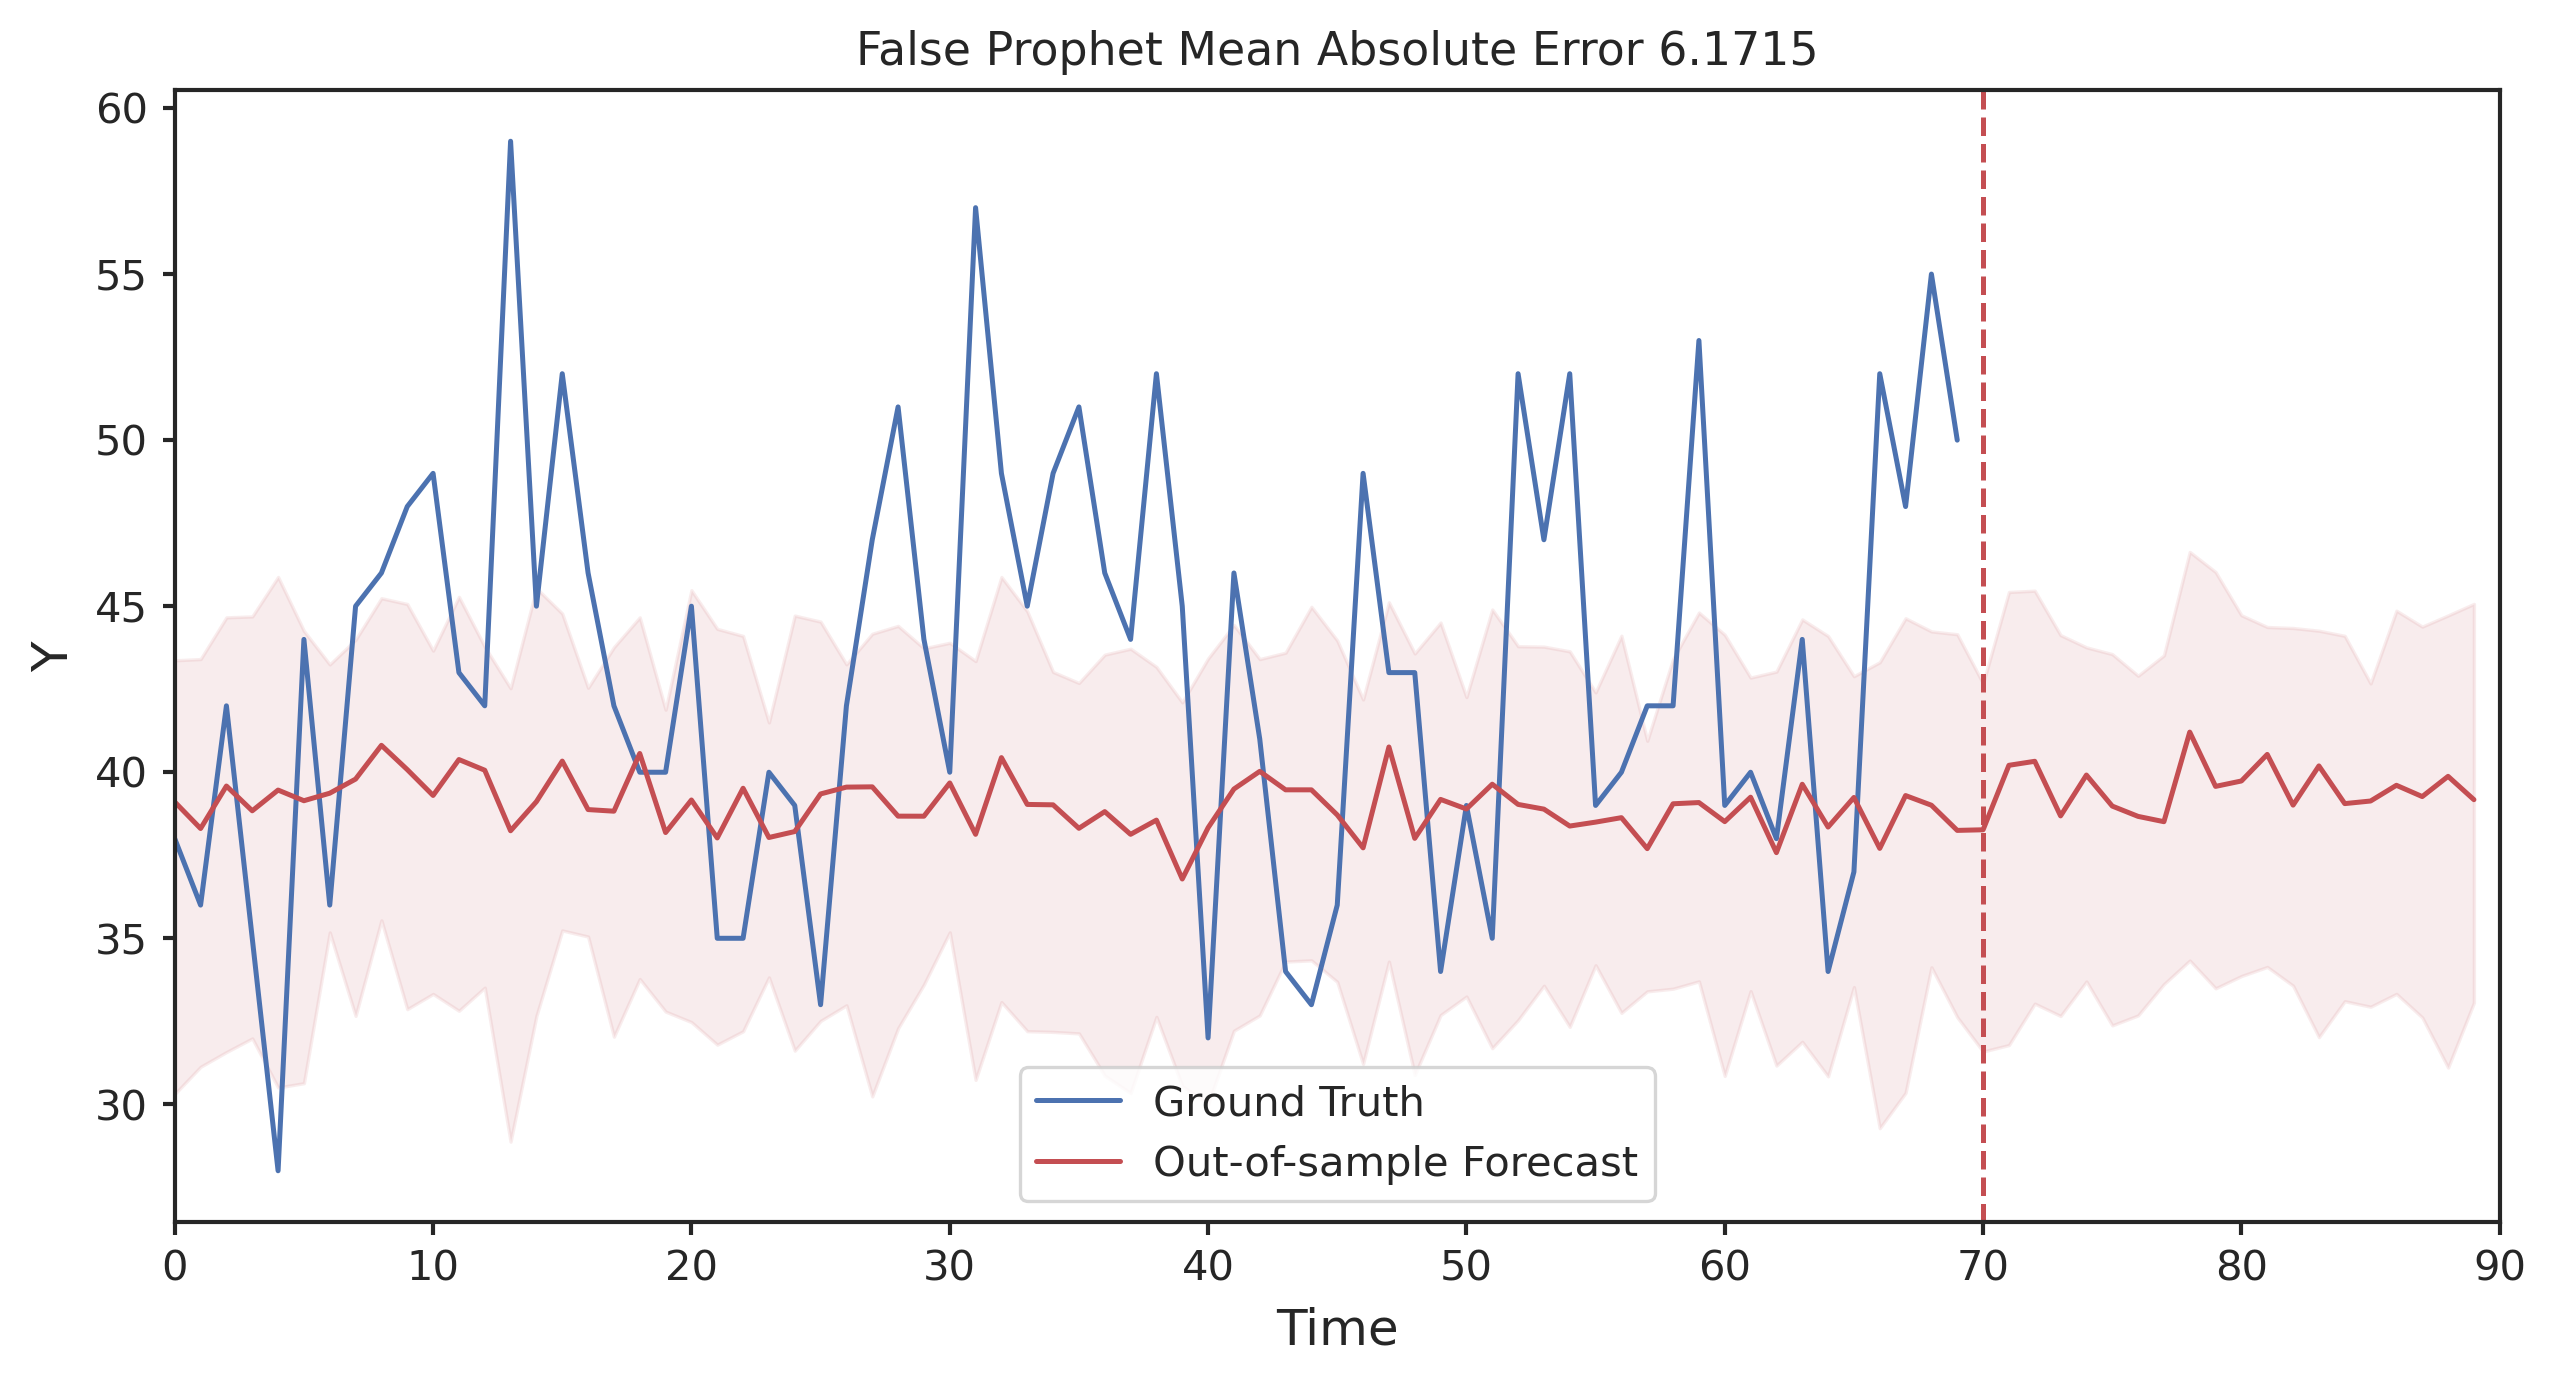

In [5]:
test_models(
    datasets={'female_birth': 70}, 
    periods=90, 
    figsize=(15, 5),
    n_boot=30
)

## Daily CO2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Testing co2_daily with Prophet


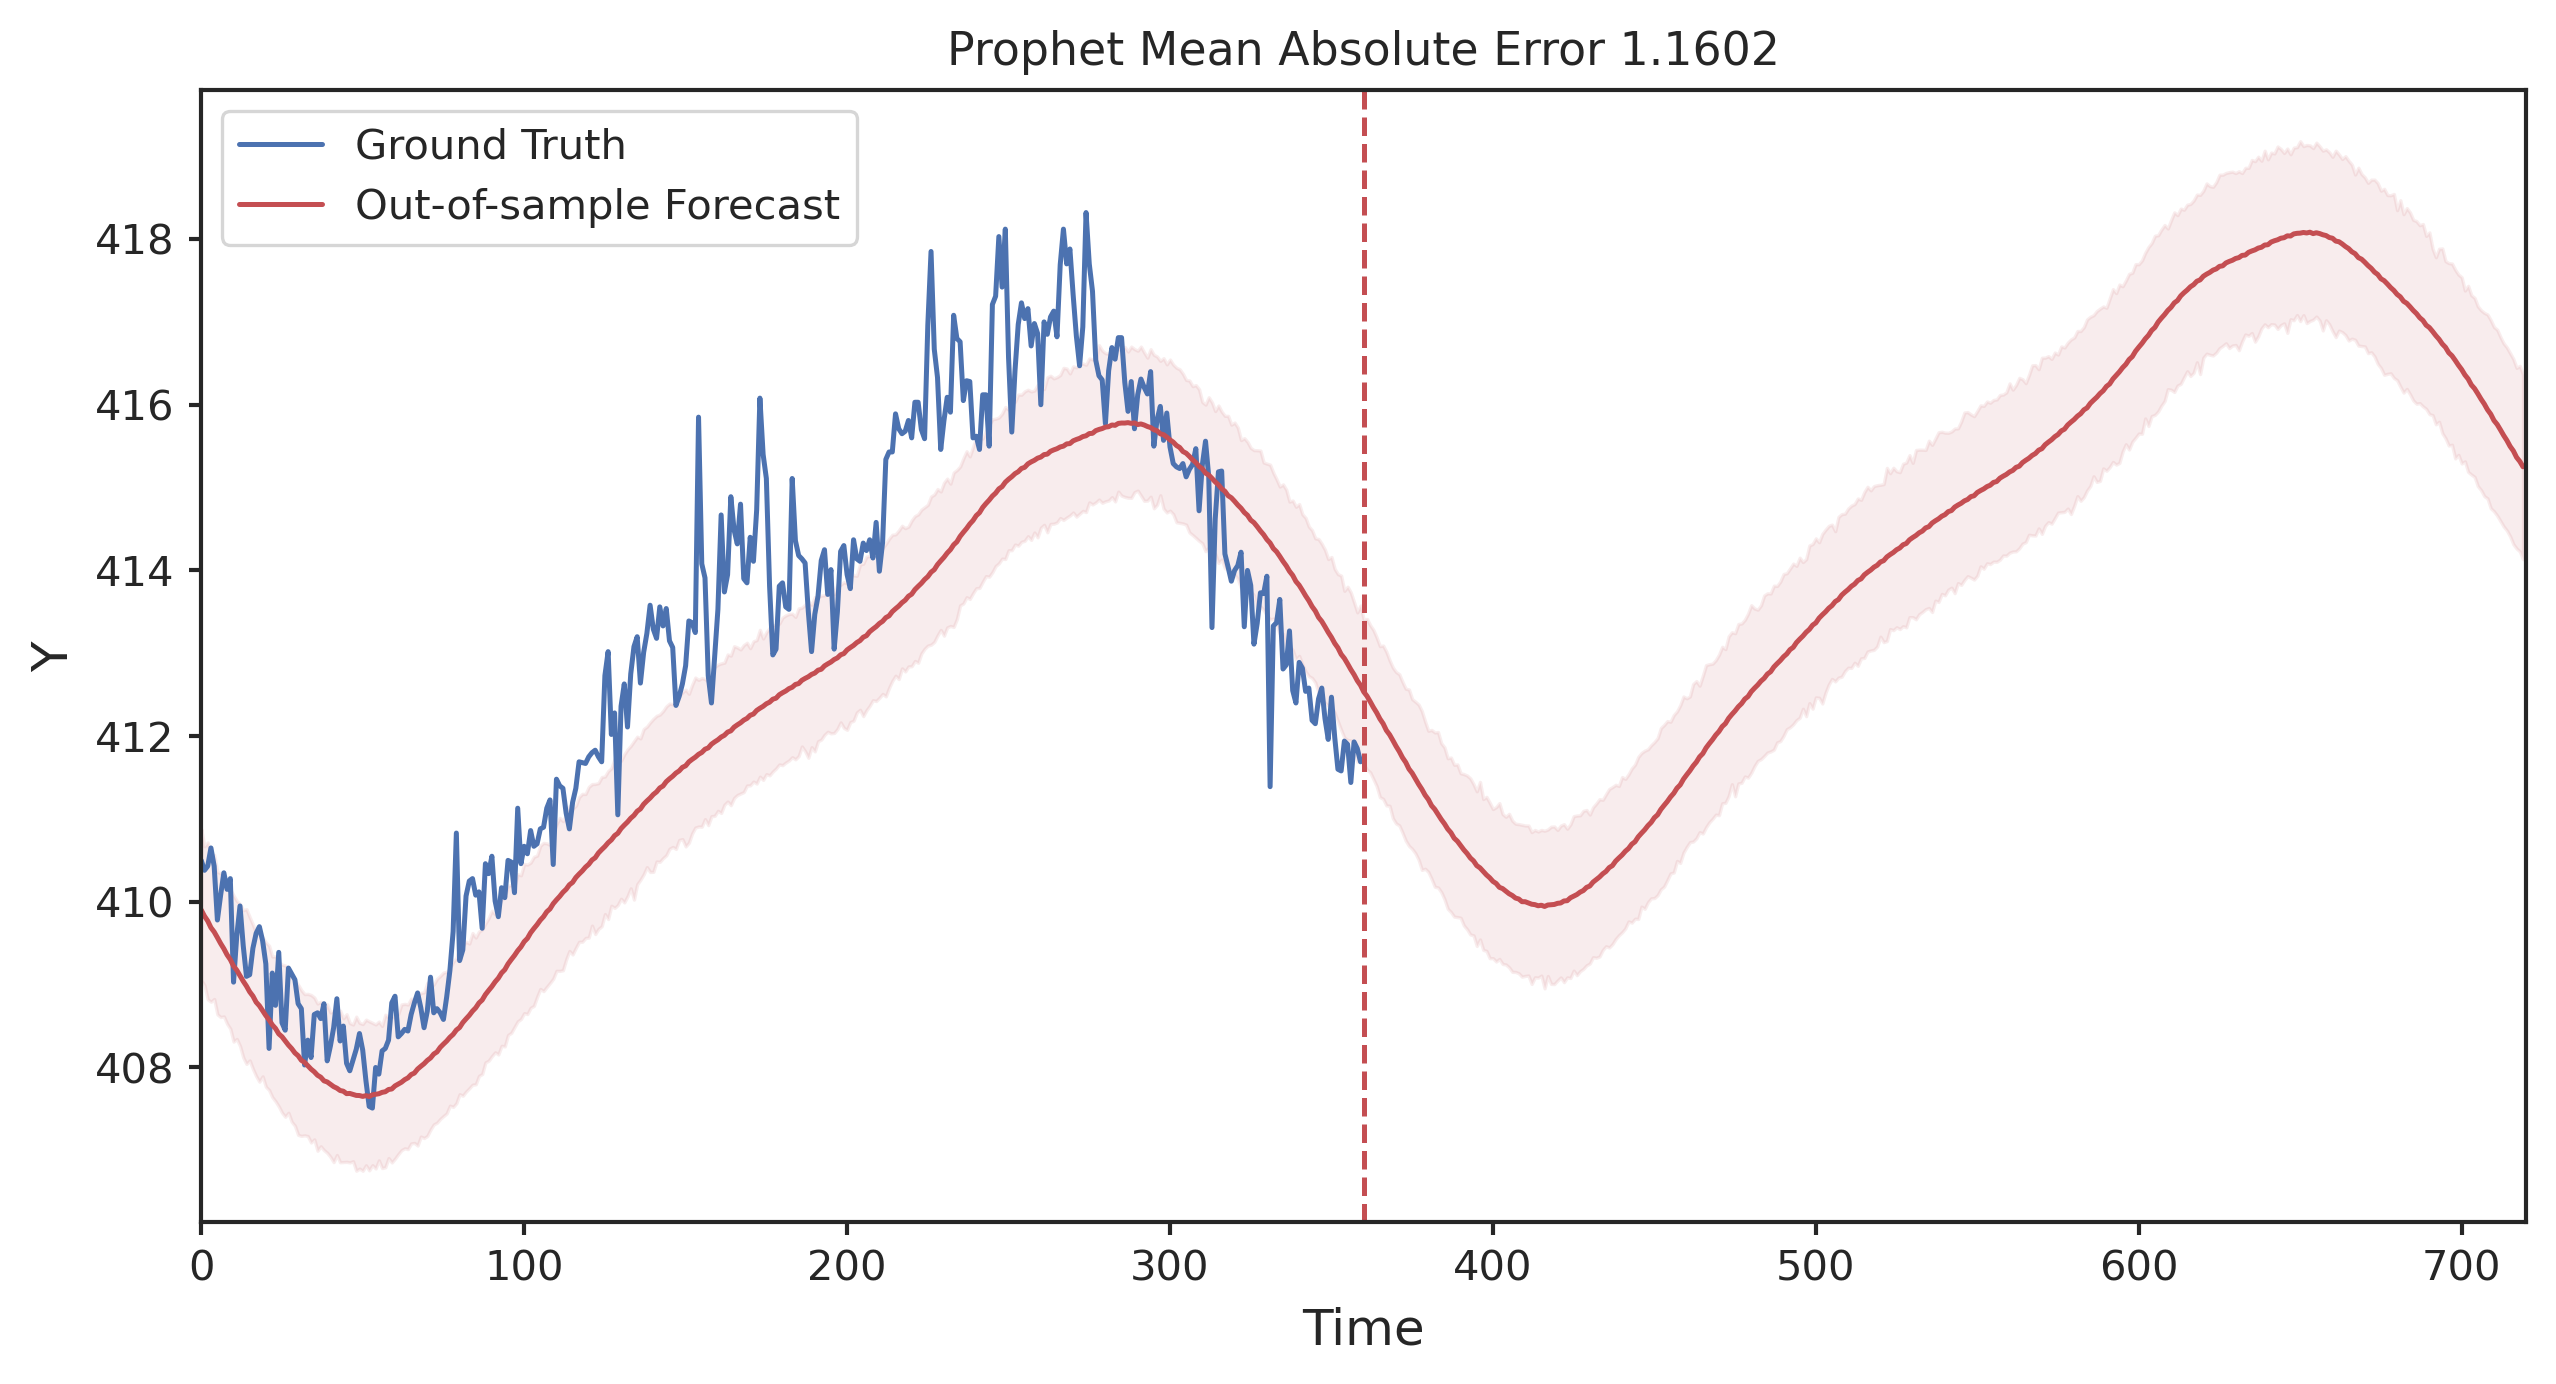

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [15:24<00:00, 30.82s/it]


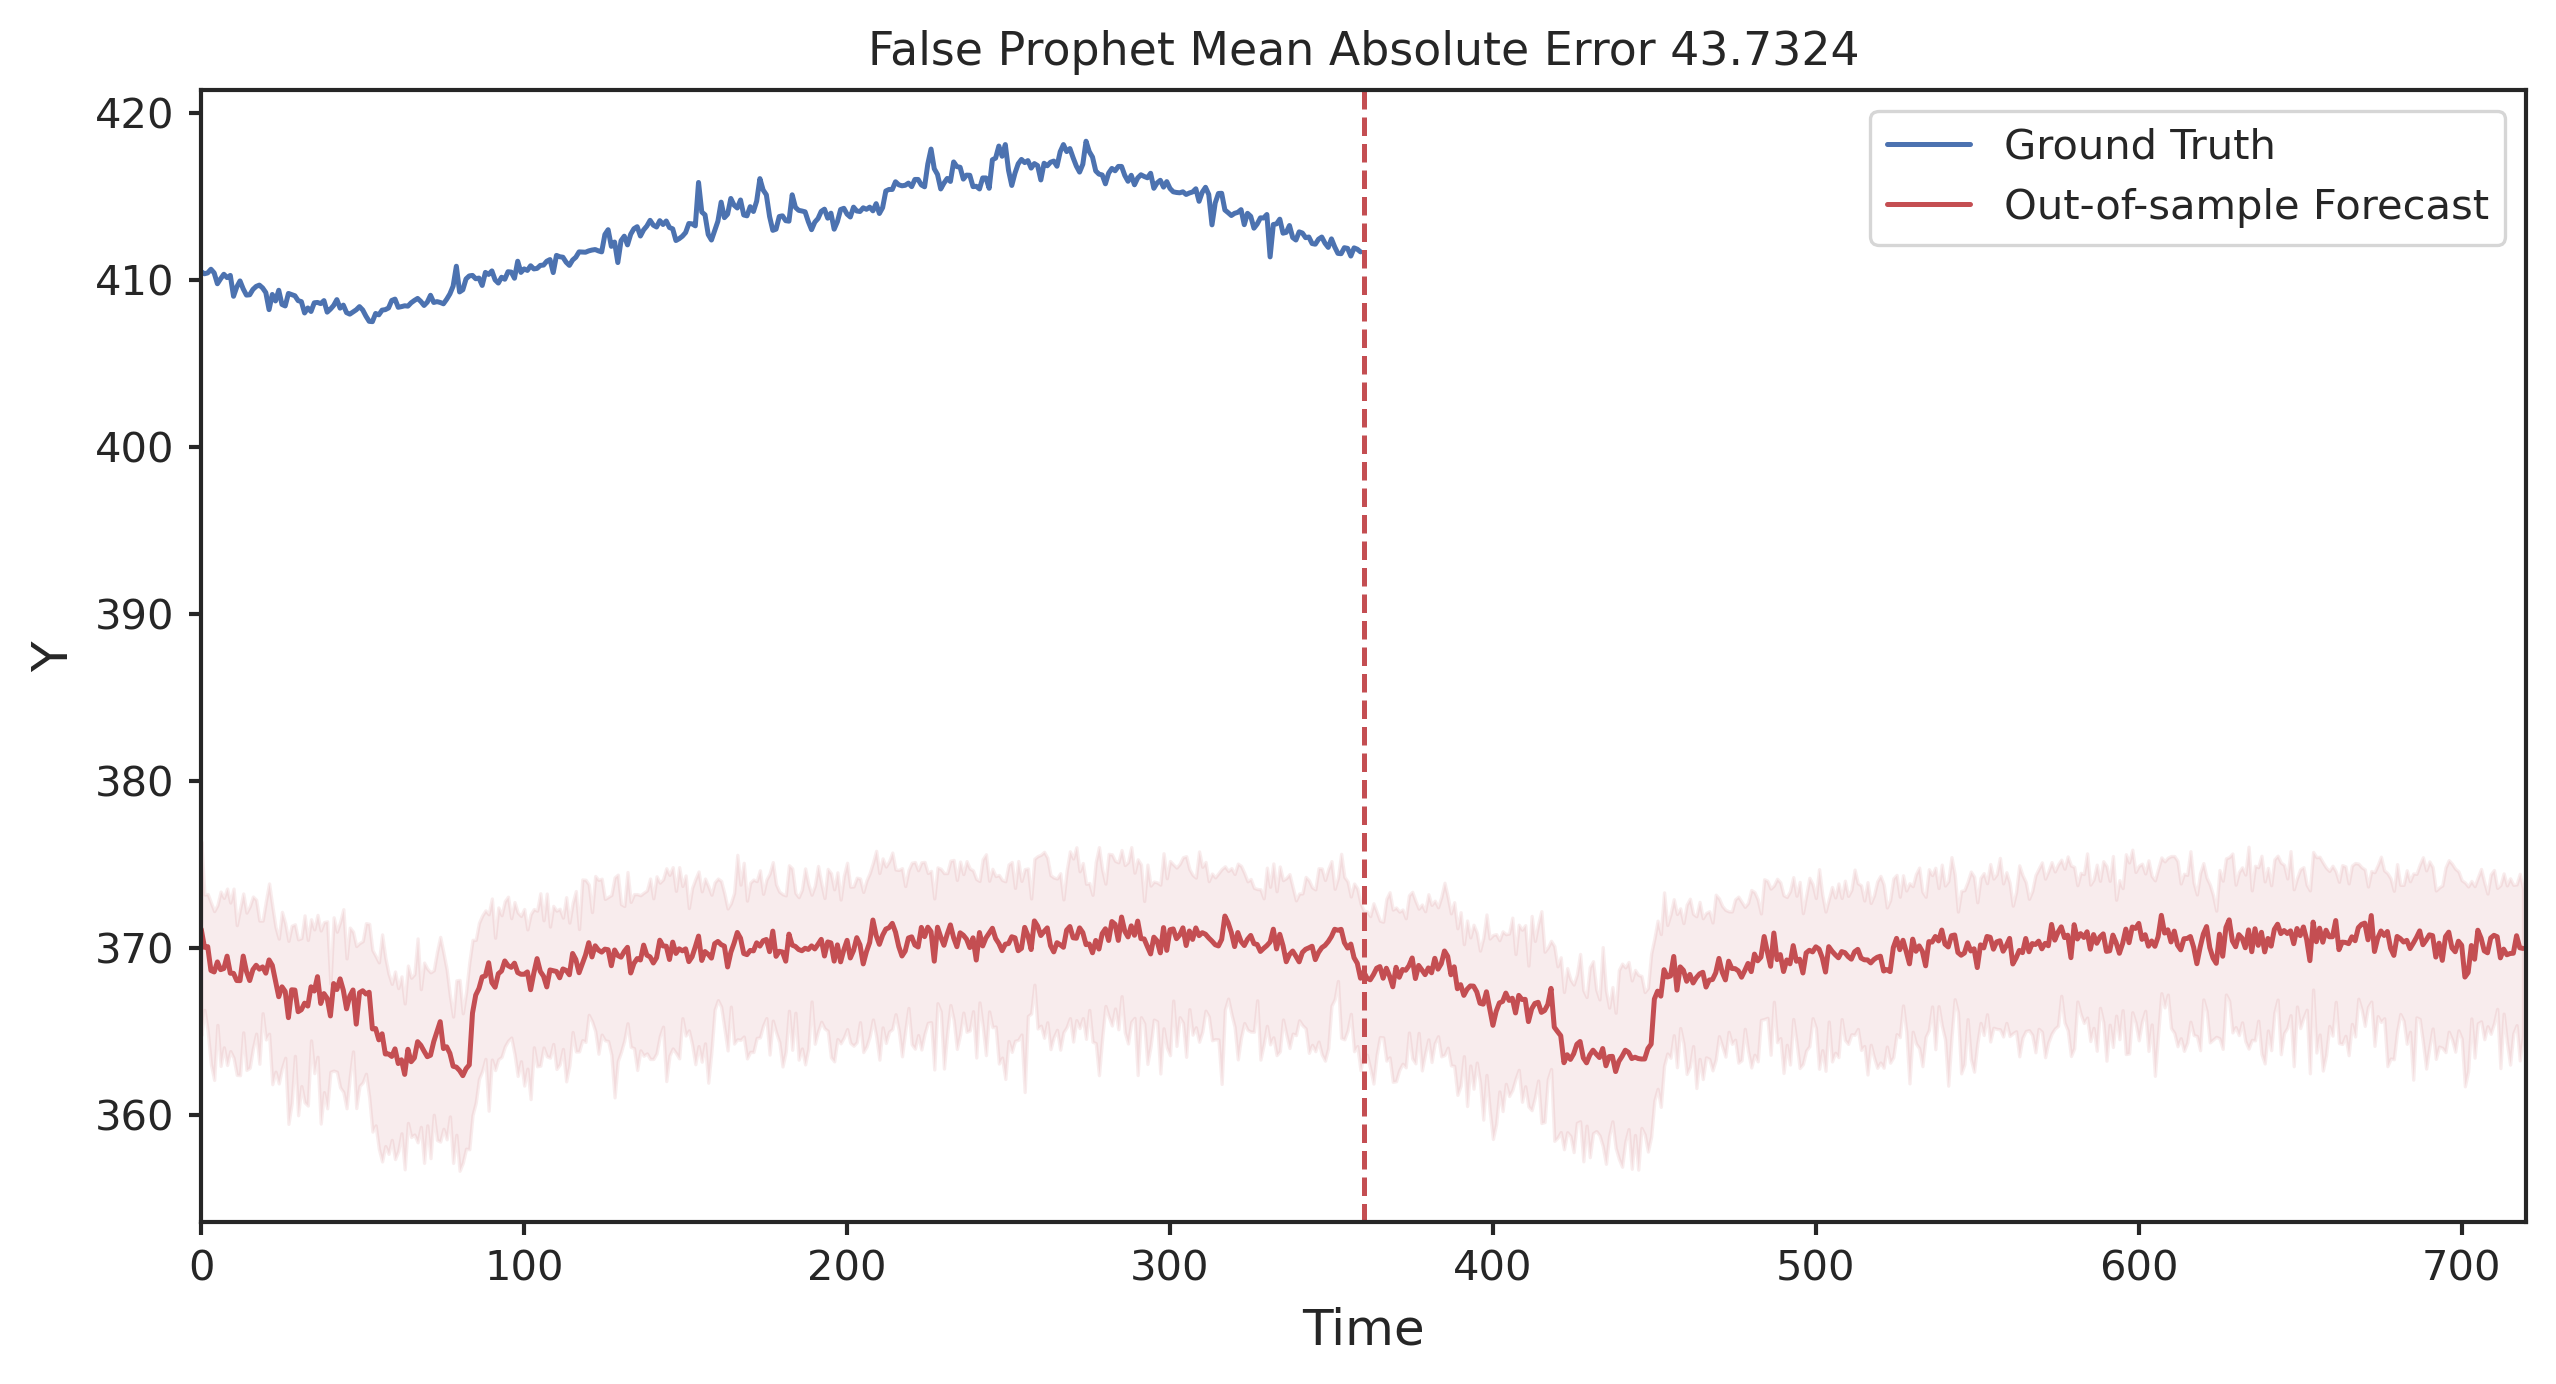

In [6]:
test_models(
    datasets={'co2_daily': 360}, 
    periods=720, 
    figsize=(15, 5),
    n_boot=30
)